In [1]:
%run config_check.py

You are currently using this configuration -
Python:  3.6.4 |Anaconda, Inc.| (default, Jan 16 2018, 18:10:19) 
[GCC 7.2.0]
Numpy:  1.14.0
Scipy:  1.0.0
Matplotlib:  2.1.2
Pystan:  2.17.1.0
ipywidgets:  7.2.1

The code was tested on Python:  3.6.4 |Anaconda, Inc.| (default, Jan 16 2018, 18:10:19) [GCC 7.2.0], Numpy:  1.14.0, Scipy:  1.0.0, Matplotlib:  2.1.2, Pystan:  2.17.1.0, ipywidgets:  7.1.1


In [1]:
# <api>
import numpy as np
from scipy.stats import norm
from matplotlib import pyplot as plt
%matplotlib inline

# Load classes and functions from the Part 1
from jupyter_cms.loader import load_notebook
smpl1 = load_notebook('./Sampling_part1.ipynb')

# Sampling methods

## Rejection sampling

The next sampling method is less efficient, but more general in the sense that it can be used even if the normalization constant of the desired density $p(x)$ is unavailable.

It is based on the idea that a sample at position $x$ should be drawn with probability $p(x)$, i.e. the height under the graph of $x$. Thus, a sample can be drawn using two random numbers as follows:

* Draw a sample $x$ from some distribution $q(x)$
* Draw a uniform number $u$ between 0 and $c q(x)$:
  - If $u < p(x)$ return the sample $x$
  - Else discard $x$ and repeat
  
Here, it is assumed that samples from $q(x)$ can be drawn efficiently. Further, the scaling constant $c$ must be choosen such that $c q(x) \geq p(x) \quad \forall x$. The plot below illustrates the idea for the Gaussian distribution:

In [2]:
# <api>
def p(x):
    """
    Unnormalized density of the standard Gaussian
    """
    return np.exp(-0.5*x**2)

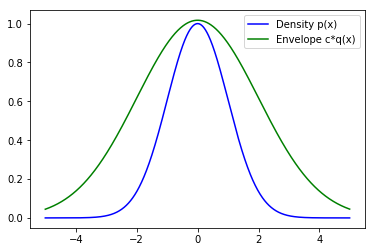

In [3]:
q = norm(loc=0, scale=2)
x = np.arange(-5,5,0.01)
plt.plot(x, p(x), 'b-', x, 5.1*q.pdf(x), 'g-')
plt.legend(['Density p(x)', 'Envelope c*q(x)']);

In [4]:
#api
class RejectionSampling (smpl1.Sampling):
    def __init__ (self, p, q, c):
        """
        q is assumed to support sampling q.rvs and density evaluation q.pdf
        """
        self.p = p
        self.q = q
        self.c = c
        self.tries = 0
        self.samples = 0
        self.last_approved = [0,0]

    def sample (self):
        while True:
            self.tries += 1
            x = self.q.rvs()
            u = np.random.uniform(low=0, high=self.c*self.q.pdf(x))
            if u < self.p(x):
                self.samples += 1
                return x
            
    def sample_all (self):
        while True:
            self.tries += 1
            x = self.q.rvs()
            u = np.random.uniform(low=0, high=self.c*self.q.pdf(x))
            if u < self.p(x):
                self.samples += 1
                self.last_approved = x
                return [x,x]
            else:
                return [self.last_approved, x]
            
    def __str__ (self):
        return "Rejection sampling: %d tries for %d samples" % (self.tries, self.samples)           

In [5]:
sampling = RejectionSampling(p=p, q=norm(loc=0, scale=2), c=5.1)

smpl1.show_sampling(sampling, plotter=smpl1.gauss_hist, 
                    f_exp=lambda x: np.power(x,2), true_exp=1.0)
print (sampling)

Output()

Rejection sampling: 2005 tries for 1000 samples


Rejection sampling tends to work well, if a distribution $q(x)$ which closely approximates $p(x)$ from above can be found. Otherwise, the area between the curves will be large leading to a high rejection rate. Especially in high dimensions this is a severe problem.

A standard example to illustrate the difficulties arising in high dimensions is a 2-dimensional Gaussian with high correlation:

In [6]:
# <api>
from scipy.stats import multivariate_normal
p2d = multivariate_normal(mean=[0,0], cov=[[1, 0.99],[0.99, 1]])
x = np.linspace(-3, 3, 200)
y = np.linspace(-3, 3, 200)
X, Y = np.meshgrid(x, y)
XY = np.empty(X.shape + (2,))
XY[:,:,0] = X; XY[:,:,1] = Y

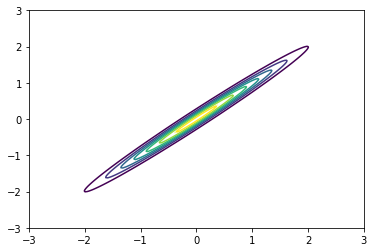

In [7]:
plt.contour(X, Y, p2d.pdf(XY));

The problem now is that an isotropic distribution is not a good fit since the above density has two very different length scales. Having a tight fit between the sampling and target density becomes even more important in high dimensions.

For the sake of argument, consider the problem of sampling from a multi-variate Gaussian with mean zero and diagonal covariance matrix $\sigma_p^2 \mathbf{I}_D$ where $\mathbf{I}_D$ denotes the $D \times D$ identity matrix. As a sampling density, we choose another Gaussian with covariance $\sigma_q^2 \mathbf{I}_D$. The condition, $c q \geq p$ now requires that $\sigma_q^2 \geq \sigma_p^2$ and the optimal (smallest) value of $c$ is found to be $\left( \frac{\sigma_p}{\sigma_q} \right)^D$. Then, the acceptance probability is given by the ratio of volumes under $p(x)$ and $c q(x)$ which is just $\frac{1}{c}$ since both distributions are normalized. Thus, the acceptance probability vanishes exponentially in $D$.

**Exercise:** Illustrate this effect when $\sigma_q$ exceeds $\sigma_p$ by $1 \%$.

In [8]:
# <api>
def gauss_hist2d (ax, data, bins):
    x = np.array(data)[:,0]
    y = np.array(data)[:,1]
    ax.hist2d(x, y, bins, normed=True)

In [9]:
q = multivariate_normal(mean=[0,0], cov=np.eye(2))
sampling = RejectionSampling(p=p2d.pdf, q=q, c=p2d.pdf([0,0])/q.pdf([0,0]))

### How can we draw the expectation for 2D data?
smpl1.show_sampling(sampling, plotter=gauss_hist2d, exp=False)
print(sampling)

Output()

Rejection sampling: 8391 tries for 1000 samples


With a much higher rejection rate as in the 1-dimensional example above.

The next example shows that rejection sampling fails, i.e. samples from the wrong distribution, if the condition $c q(x) \geq p(x)$ is violated:

In [10]:
sampling = RejectionSampling(p=p, q=norm(loc=0, scale=2), c=2)

smpl1.show_sampling(sampling, plotter=smpl1.gauss_hist, 
                    f_exp=lambda x: np.power(x,2), true_exp=1.4)

### What is the true value for the expectation hier? Why 1.4?

print(sampling)

Output()

Rejection sampling: 1412 tries for 1000 samples


## Importance sampling

Importance sampling tries to fix the inefficiency of rejection sampling, by assigning weights to each sample instead of rejecting. It is based on the observation that
$$ \mathbb{E}_p[f] = \int f(x) p(x) dx = \int f(x) \frac{p(x)}{q(x)} q(x) dx = \mathbb{E}_q[f \frac{p}{q}] $$
for any function $f(x)$.

Thus, instead of using samples $x_1,\ldots,x_N$ from $p(x)$ to approximate the expectation $\mathbb{E}_p[f]$ of $f$ under $p$ as
$$ \mathbb{E}_p[f] \approx \frac{1}{N} \sum_{i=1}^n f(x_i) $$
we can just as well use samples from some other distribution $q(x)$ and evaluate the expectation of $f \frac{p}{q}$ under $q$.

This scheme can easily be extended when the normalization constant of $p(x)$ is not available, i.e. $p(x) = \frac{1}{Z} \hat{p}(x)$. Then,
$$ \mathbb{E}_p[f] = \int \frac{1}{Z} f(x) \hat{p}(x) dx = \frac{1}{Z} \mathbb{E}_q[f \frac{\hat{p}}{q}] $$
and since $\int p(x) dx = 1 = \frac{1}{Z} \int \frac{\hat{p}(x)}{q(x)} q(x) dx$, $Z$ can be found via importance sampling as well:
$$ Z = \int \frac{\hat{p}(x)}{q(x)} q(x) dx = \mathbb{E}_q[\frac{\hat{p}}{q}]$$

Thus, assuming that we have samples $x_1,\ldots,x_n$ from $q$, the expectation $\mathbb{E}_p[f]$ can be approximated as
$$ \mathbb{E}_p[f] \approx \frac{\sum_{i=1}^N f(x_i) w_i}{\sum_{i=1}^N w_i} $$
with $w_i = \frac{\hat{p}(x_i)}{q(x_i)}$ being the **_weight_** of sample $x_i$

In [11]:
# <api>
class ImportanceSampling (smpl1.Sampling):
    def __init__(self, log_p, q):
        """
        q is assumed to support sampling q.rvs and density evaluation q.pdf
        """
        self.log_p = log_p
        self.q = q
        
    def sample (self):
        """
        Note: Importance sampling returns a sample and its associated weight
        """
        x = self.q.rvs()
        w = np.exp(self.log_p(x) - self.q.logpdf(x))
        return [x,w]

In [12]:
# <api>
def weighted_gauss_hist (ax, weighted_data, bins):
    x = np.arange(-4,4,0.01)
    ax.hist(np.array(weighted_data)[:,0], bins, normed=True, 
            weights=np.array(weighted_data)[:,1])
    ax.plot(x, smpl1.phi(x), 'r-', alpha=0.7)

In [13]:
sampling = ImportanceSampling(log_p=lambda x: np.log(p(x)), q=norm(loc=1,scale=2))

smpl1.show_sampling(sampling, plotter=weighted_gauss_hist, 
                    f_exp=lambda x: np.array(x[0])[:,1], true_exp=np.sqrt(2*np.pi))

Output()

We can also approximate the normalization constant of $p(x) = e^{-\frac{1}{2} x^2}$ by the mean of the sample weights:

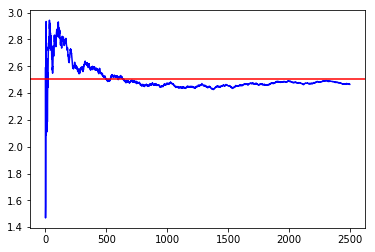

In [14]:
smpl1.show_expectation(sampling, lambda x: x[1]) # f extracts weight
plt.axhline(np.sqrt(2*np.pi), color='r'); # true normalization constant

Importance sampling can fail miserably if $q$ has thinner tails as $p$. In this case, the weights $\frac{p(x)}{q(x)}$ can become arbitrarily large and dominate the weighted samples!

This effect is demonstrated below:

In [15]:
sampling = ImportanceSampling(log_p=lambda x: np.log(p(x)), q=norm(loc=0,scale=0.25))

smpl1.show_sampling(sampling, plotter=weighted_gauss_hist,  
                    f_exp=lambda x: np.array(x[0])[:,1], true_exp=1.0)
### What is the true value for the expectation hier?

Output()

Is there a diagnostic to detect this type of problem?

In general, detecting the failure of a sampling methods can be quite difficult. Nevertheless the importance weights can give us some information about the effectiveness of importance sampling. We noted above, that the variance of the standard Monte-Carlo estimate using $N$ samples is given by
$$ \mathbb{V}ar_p[\frac{1}{N} \sum_{i=1}^N f(x_i)] = \frac{1}{N} \mathbb{V}ar_p[f] $$
Similarly, we could compute the variance of the weighted average used in importance sampling
$$ \mathbb{V}ar_p[\sum_{i=1}^N \frac{w_i}{\sum_{i=1}^N w_i} f(x_i)] = \frac{\sum_{i=1}^N w_i^2}{(\sum_{i=1}^N w_i)^2} \mathbb{V}ar_p[f] $$
Thus, by comparing coefficients we can define
$$ N_{eff} = \frac{(\sum_{i=1}^N w_i)^2}{\sum_{i=1}^N w_i^2} $$
as an approximate effective sampling size.

Note: This derivation is by no means exact, as the weights $w_i$ are actually not fixed, but dependent on the samples $x_i$. Thus, they are in particular not necessarily independent of $f(x_i)$ ...

In [16]:
# <api>
def ess (x):
    """
    Effective sample size of weighted samples x
    """
    w = np.array(x)[:,1] # extract weight
    return np.sum(w)**2/np.sum(w**2)

In [17]:
# <api>
def plt_ess (ax, weighted_data, bins):
    weighted_gauss_hist(ax, weighted_data, bins)    
    ax.text(1, 0.35, "N_eff = "+str(ess(weighted_data)))

In [18]:
smpl1.show_sampling(sampling, plotter=plt_ess, f_exp=lambda x: np.array(x[0])[:,1], 
                    true_exp=2.5)
### What is the true value for the expectation hier?

Output()

Some theoretical remarks on importance sampling:

* What is the optimal choice for $q$?

  Remember that the variance of a Monte-Carlo estimate for $\mu = \mathbb{E}_p[f]$ is given by $\frac{1}{N} \mathbb{V}ar_p[f]$. In importance sampling, the integrand is changed to $f \frac{p}{q}$ and the expectation is then evaluated with respect to the sampling density $q$. It is easy to see that the optimal choice would be $q(x) = \frac{p(x) f(x)}{\mu}$ with variance
  $$ \mathbb{V}ar_q[ f \frac{p}{q} ] = \mathbb{V}ar_q[ \mu ] = 0 $$
  Note: While optimal this choice is infeasible since the normalization constant of this $q$ is equal to $\mu$, i.e. the mean of $f$ which is to be computed in the first place.

* In general, importance sampling can be considered a variance reduction technique. We compute $$ \mathbb{V}ar_p[f] - \mathbb{V}ar_q[f \frac{p}{q}] = \int f^2(x) (1 - \frac{p(x)}{q(x)}) p(x) dx $$
  Thus, importance sampling reduces the variances when $\frac{p(x)}{q(x)} < 1$ if $f(x) p(x)$ large, while allowing for $\frac{p(x)}{q(x)} > 1$ if $f(x) p(x)$ is small.

**Example**: Pricing an (out-of-the-money) Asian call option with importance sampling

Consider a Black-Scholes world, i.e. the stock price $S_t$ follows a geometric Brownian motion, i.e. $$ S_t = S_0 e^{(r - \frac{\sigma^2}{2}) t + \sigma W_t}$$ where $W_t$ denotes a Brownian motion.

Now, assume that an Asian call with strike $K$ and expiring at time $T$ pays
$$ a(S) = \max ( 0, \frac{1}{M} \sum_{i=1}^M S_{i \frac{T}{M}} - K ), $$
i.e. the stock price is averaged over days $i \frac{T}{M}$ for $i=1,\ldots,M$ and then compared with the strike $K$. Using the above formula for the stock price, we can compute $S_{i \frac{T}{M}} = S_0 e^{(r - \frac{\sigma^2}{2}) i \frac{T}{M} + \sigma \sqrt{\frac{T}{M}} (X_1 + \ldots + X_i)}$ where $X_i \sim \mathcal{N}(0,1)$ since the Brownian motion is the cumulative sum of standard normal increments.

The risk-neutral option price is then computed as
$$ \mathbb{E}_S[ e^{-rT} a(S) ] $$

Below, we compute the price for an option that is vastly out of the money, i.e. $K \gg S_0$

In [19]:
# <api>
def stock_price (S_0, r, sigma, T, X):
    """
    Stock prices S_{i\frac{T}{M}} given a sequence X[1], ..., X[M] of normal increments
    """
    M = X.size
    i = np.arange(M) + 1 # i = 1,...,M
    return S_0*np.exp( (r-sigma**2/2.0)*i*T/M + sigma*np.sqrt(T/M)*np.cumsum(X) )

def a(S, K):
    return np.max([0, np.mean(S) - K])

class NormalIncrements (smpl1.Sampling):
    def __init__ (self, M):
        self.M = M
    def sample(self):
        return np.random.normal(size=(self.M,))
    
def out_of_money (X):
    sigma = 0.25/np.sqrt(365) # 25% yearly volatility
    S = stock_price(100, 0, sigma, 6*30, X)
    return a(S, 130)

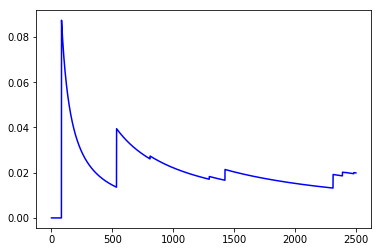

In [21]:
M = 100
smpl1.show_expectation(NormalIncrements(M), out_of_money)

Next, the same with importance sampling shifting up the mean of the sampling distribution:

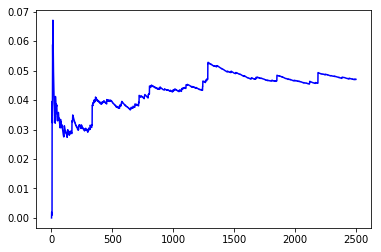

In [22]:
smpl1.show_expectation(ImportanceSampling(log_p = multivariate_normal(mean=np.zeros(10)).logpdf,
                                          q = multivariate_normal(mean=1.0*np.ones(10))), 
                       lambda X: X[1]*out_of_money(X[0]))